# Первые выводы

Полезные признаки :    Бесполезные признаки:    Вредные признаки:
string.1               enum                     interval
string.2               set[string]              count
addr
count.1
count.2

In [ ]:
После удаления бесполезных и вредных признаков из первых выводов модель стала лучше различать
'C&C' и 'C&C-HeartBeat', а общее качество вырасло:
    recall с 0.5534321707087154 до
             0.5544737206404873
    f1 с 0.46045831991662173 до
         0.46289757292980255

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# для подбора гипер параметров в моделях
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, \
                            confusion_matrix, precision_score, recall_score, f1_score
# метрики с функциями потерь

%matplotlib inline 
# отображает графику в юпитере
%config IPCompleter.greedy=True 
# должно ускорять работу таба

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import csv
from IPython.display import HTML, display

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [5]:
from sklearn.externals import joblib
# для сохранения обученных моделей

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, RidgeClassifier, \
                                 PassiveAggressiveClassifier, \
                                 LogisticRegressionCV

In [60]:
def con_mat(y_test, y_pred):
    array = confusion_matrix(y_test, y_pred)
    array = array / array.astype(np.float).sum(axis=1, keepdims=True) # нормализация
    df_cm = pd.DataFrame(array, index = ['-','PartOfAHorizontalPortScan','C&C','Attack','Okiru','DDoS','C&C-HeartBeat', \
            'C&C-Torii', 'FileDownload'],
                      columns = ['-','PartOfAHorizontalPortScan','C&C','Attack','Okiru','DDoS','C&C-HeartBeat', \
            'C&C-Torii', 'FileDownload'])
    plt.figure(figsize = (12,8))
    sns.heatmap(df_cm, annot=True);
# код для отображения матрицы ошибки

In [7]:
big = pd.read_csv('data_9', sep = '	')
big = big.drop('Unnamed: 0', axis = 1)

In [13]:
plt.rcParams['figure.figsize'] = [18, 10]

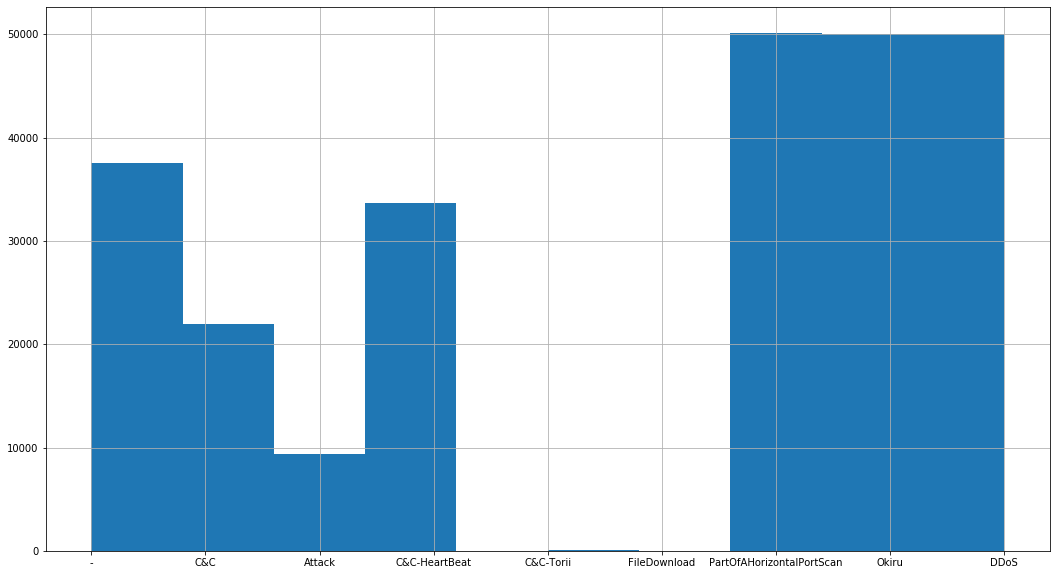

In [14]:
big['string.5'].hist();

In [22]:
big['string.5'].value_counts()

PartOfAHorizontalPortScan    50122
DDoS                         50001
Okiru                        50000
-                            37590
C&C-HeartBeat                33673
C&C                          21995
Attack                        9398
C&C-Torii                       30
FileDownload                    18
Name: string.5, dtype: int64

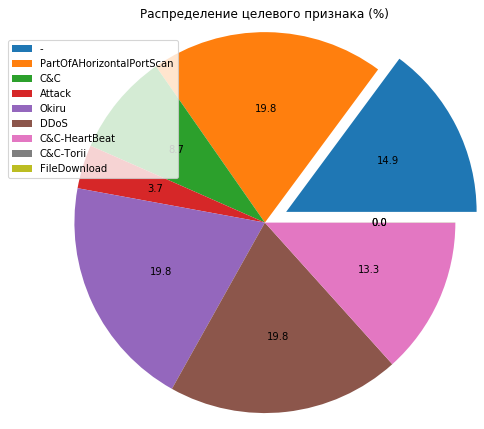

In [35]:
data_names = ['-','PartOfAHorizontalPortScan','C&C','Attack','Okiru','DDoS','C&C-HeartBeat', \
            'C&C-Torii', 'FileDownload']
data_values = [37590,50122,21995,9398,50000,50001,33673,30, 18]

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 2160 / dpi) )
mpl.rcParams.update({'font.size': 9})

plt.title('Распределение целевого признака (%)')

xs = range(len(data_names))

plt.pie( 
    data_values, autopct='%.1f', radius = 1.2,
    explode = [0.15] + [0 for _ in range(len(data_names) - 1)] )
plt.legend(
    bbox_to_anchor = (-0.16, 0.60, 0.25, 0.25),
    loc = 'lower left', labels = data_names )
fig.savefig('pie.png')

In [36]:
start = big

In [37]:
big.loc[big['string.5'] == '-', 'string.5'] = 0
big.loc[big['string.5'] == 'PartOfAHorizontalPortScan', 'string.5'] = 1
big.loc[big['string.5'] == 'C&C', 'string.5'] = 2
big.loc[big['string.5'] == 'Attack', 'string.5'] = 3
big.loc[big['string.5'] == 'Okiru', 'string.5'] = 4
big.loc[big['string.5'] == 'DDoS', 'string.5'] = 5
big.loc[big['string.5'] == 'C&C-HeartBeat', 'string.5'] = 6
big.loc[big['string.5'] == 'C&C-Torii', 'string.5'] = 7
big.loc[big['string.5'] == 'FileDownload', 'string.5'] = 8

In [38]:
big['string.5'].value_counts()

1    50122
5    50001
4    50000
0    37590
6    33673
2    21995
3     9398
7       30
8       18
Name: string.5, dtype: int64

In [181]:
big = big.drop('string', axis = 1)

big = big.drop('time', axis = 1)

big = big.drop('bool', axis = 1)
big = big.drop('bool.1', axis = 1)
big = big.drop('string.4', axis = 1)
# значения признаков bool и bool.1 одинаковы для всех наблюдений
# признак string.4 имеет частичный ответ ожидаемый от модели

big.loc[big['interval'] == '-', 'interval'] = '-1'
big.loc[big['count'] == '-', 'count'] = '-1'
big.loc[big['count.1'] == '-', 'count.1'] = '-1'

big['interval'] = big['interval'].astype(float)
big['count'] = big['count'].astype(int)
big['count.1'] = big['count.1'].astype(int)
# заменяем пропуски на значение -1 и приводим признаки к числовому типу

labelencoder = LabelEncoder()

big["addr"] = labelencoder.fit_transform(big["addr"])
big["addr.1"] = labelencoder.fit_transform(big["addr.1"])
big["enum"] = labelencoder.fit_transform(big["enum"])
big["string.1"] = labelencoder.fit_transform(big["string.1"])
big["string.2"] = labelencoder.fit_transform(big["string.2"])
big["string.3"] = labelencoder.fit_transform(big["string.3"])
big["set[string]"] = labelencoder.fit_transform(big["set[string]"])
# преобразуем качественные признаки в числовые лабел энкодером (каждому значению признака присваиваем число)

In [47]:
big

,addr,port,addr.1,port.1,enum,string.1,interval,count,count.1,string.2,count.2,string.3,count.3,count.4,count.5,count.6,set[string],string.5
0,1709,58687,67767,123,2,0,0.114184,48,48,10,0,12,1,76,1,76,1,0
1,1709,1900,75195,1900,2,0,160.367579,7536,0,6,0,5,24,8208,0,0,1,0
2,1709,32893,67768,123,2,0,0.016986,48,48,10,0,12,1,76,1,76,1,0
3,1709,53395,62628,443,1,0,0.003497,0,0,10,0,140,5,212,3,144,1,0
4,1709,52801,41560,53,2,2,0.036724,34,311,10,0,12,1,62,1,339,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252822,1716,24104,3554,23,1,0,-1.000000,-1,-1,6,0,25,1,40,0,0,1,0
252823,1716,52989,77180,23,1,0,-1.000000,-1,-1,6,0,25,1,40,0,0,1,0
252824,1716,24104,2962,23,1,0,-1.000000,-1,-1,6,0,25,1,40,0,0,1,0
252825,1716,52989,97490,23,1,0,-1.000000,-1,-1,6,0,25,1,40,0,0,1,0


In [174]:
y = big['string.5']
x = big.drop('string.5', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10, test_size=0.6)

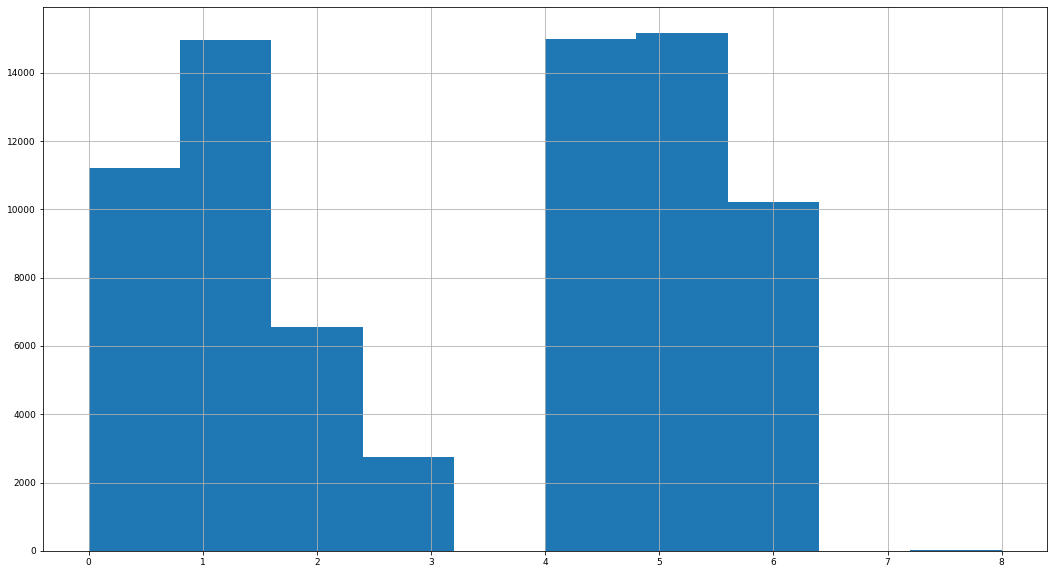

In [49]:
y_train.hist(); 

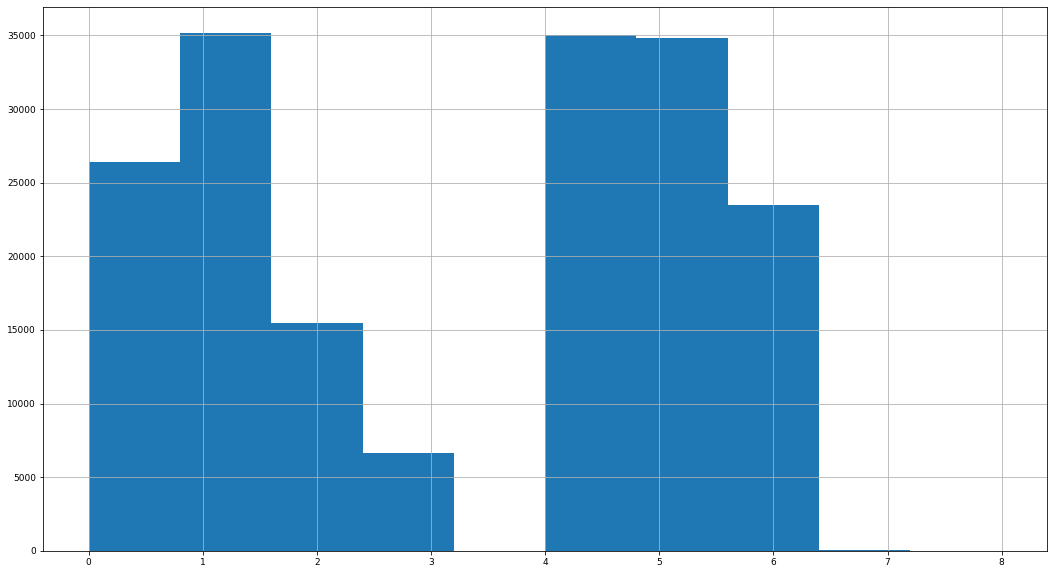

In [50]:
y_test.hist();

In [52]:
y_train.value_counts()

5    15167
4    14980
1    14965
0    11208
6    10209
2     6549
3     2752
8       10
7        8
Name: string.5, dtype: int64

In [53]:
y_test.value_counts()

1    35157
4    35020
5    34834
0    26382
6    23464
2    15446
3     6646
7       22
8        8
Name: string.5, dtype: int64

# Метод гауссовского наивного Байеса

In [91]:
grid_bayes = GaussianNB()

In [108]:
%%time
grid_bayes.fit(X_train, y_train)

Wall time: 46.1 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [109]:
y_pred = grid_bayes.predict(X_test)

In [110]:
accuracy_score(y_test, y_pred)

0.5534321707087154

In [111]:
pre = precision_score(y_test, y_pred, average = 'weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.7152960676000837,0.5534321707087154,0.46045831991662173


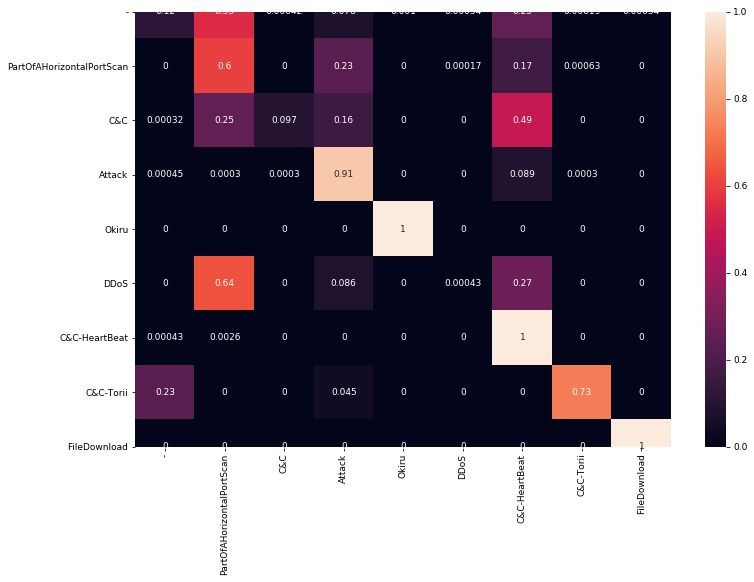

In [61]:
con_mat(y_test, y_pred)
#test_size=0.7

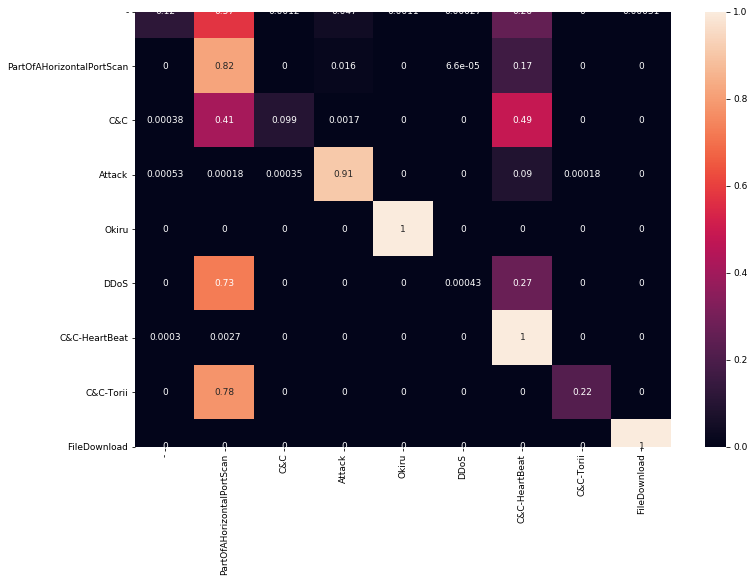

In [101]:
con_mat(y_test, y_pred)
#test_size=0.6

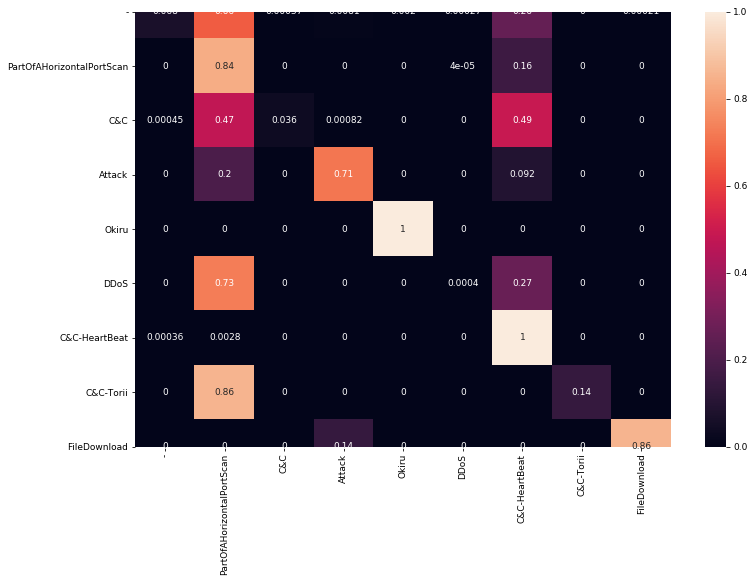

In [75]:
con_mat(y_test, y_pred)
#test_size=0.5

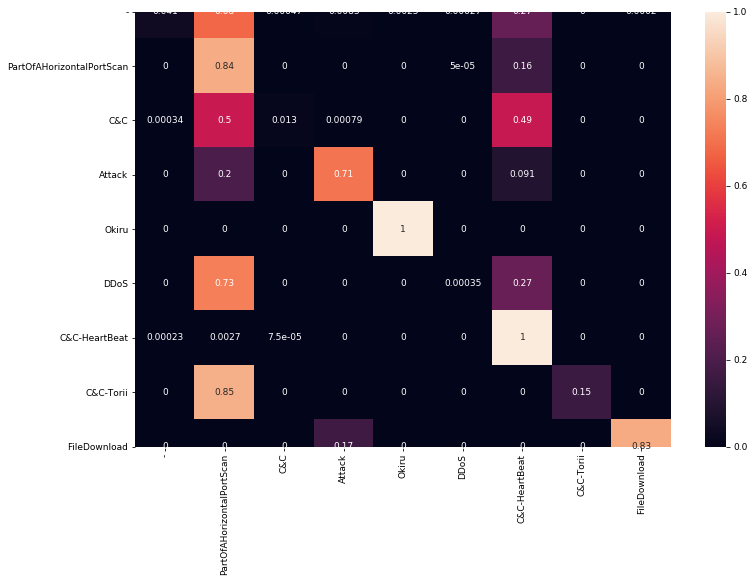

In [82]:
con_mat(y_test, y_pred)
#test_size=0.4

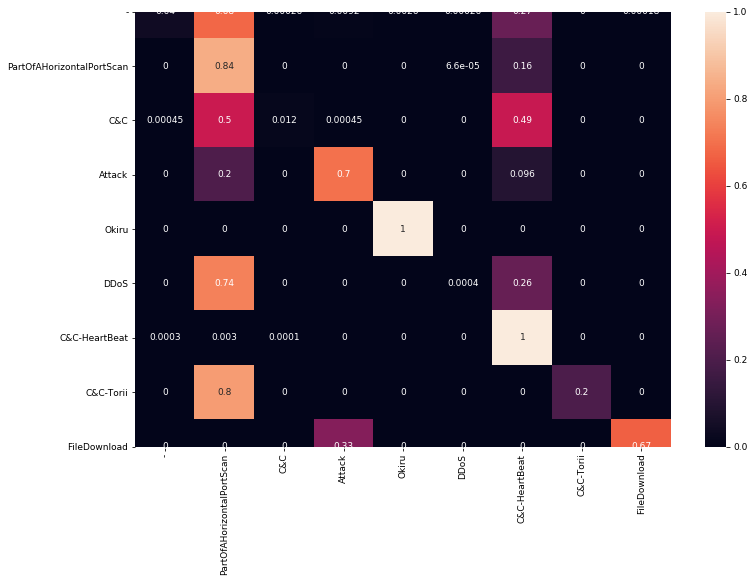

In [89]:
con_mat(y_test, y_pred)
#test_size=0.3

# big = big.drop('interval', axis = 1) -

In [118]:
%%time
grid_bayes.fit(X_train, y_train)

Wall time: 41.1 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [119]:
y_pred = grid_bayes.predict(X_test)

In [120]:
accuracy_score(y_test, y_pred)

0.5544737206404873

In [121]:
pre = precision_score(y_test, y_pred, average = 'weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.7067462587631229,0.5544737206404873,0.46289757292980255


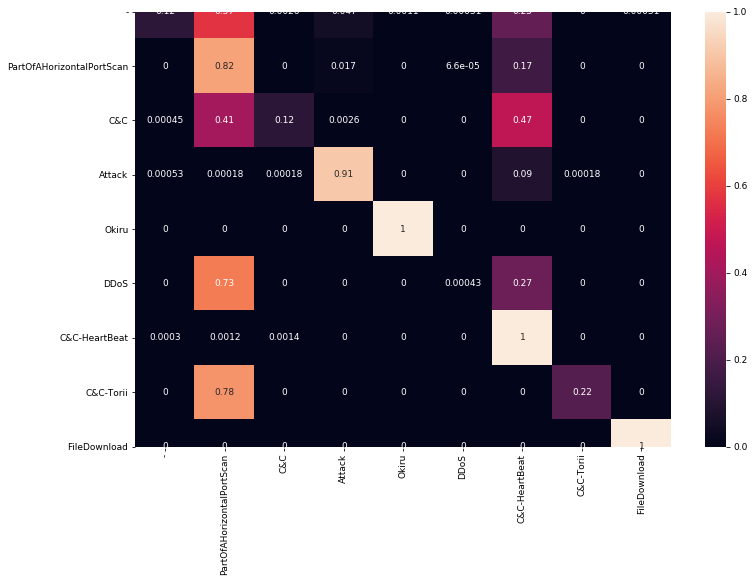

In [122]:
con_mat(y_test, y_pred)

# big = big.drop('string.1', axis = 1) +

In [126]:
%%time
grid_bayes.fit(X_train, y_train)

Wall time: 44.1 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [127]:
y_pred = grid_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.5544605364641357

In [128]:
pre = precision_score(y_test, y_pred, average = 'weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.706734029521553,0.5544605364641357,0.4628863733777004


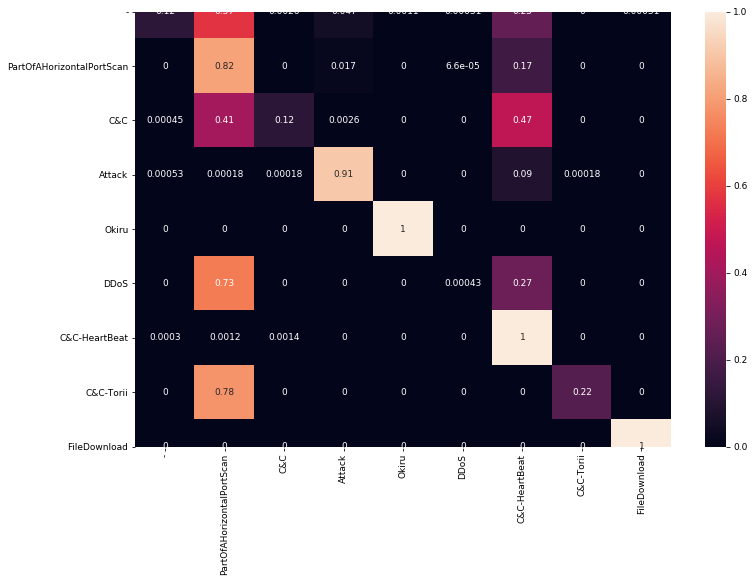

In [131]:
con_mat(y_test, y_pred)

# big = big.drop('string.2', axis = 1) +

In [133]:
%%time
grid_bayes.fit(X_train, y_train)

Wall time: 38.1 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [134]:
y_pred = grid_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.5544407601996084

In [135]:
pre = precision_score(y_test, y_pred, average = 'weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.706715694483434,0.5544407601996084,0.46286957654481076


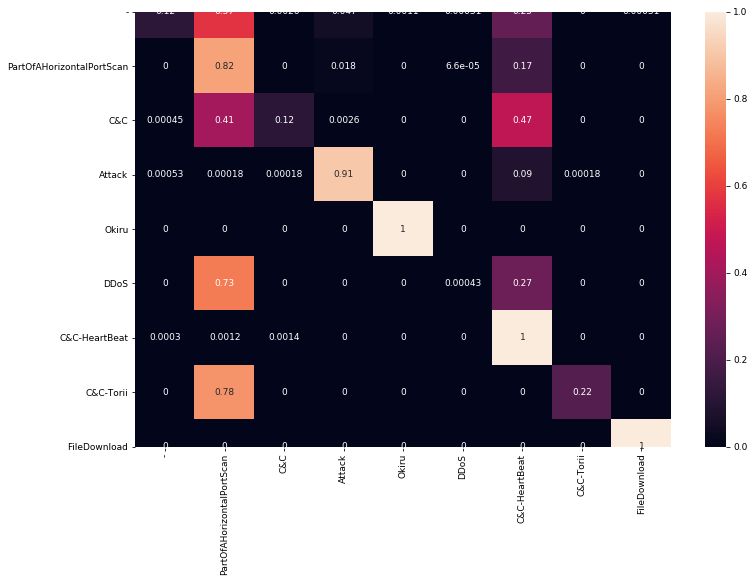

In [136]:
con_mat(y_test, y_pred)

# big = big.drop('addr', axis = 1) +

In [140]:
%%time
grid_bayes.fit(X_train, y_train)

Wall time: 39.1 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [141]:
y_pred = grid_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.536859661034826

In [142]:
pre = precision_score(y_test, y_pred, average = 'weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.6711744976606534,0.536859661034826,0.42873181160763474


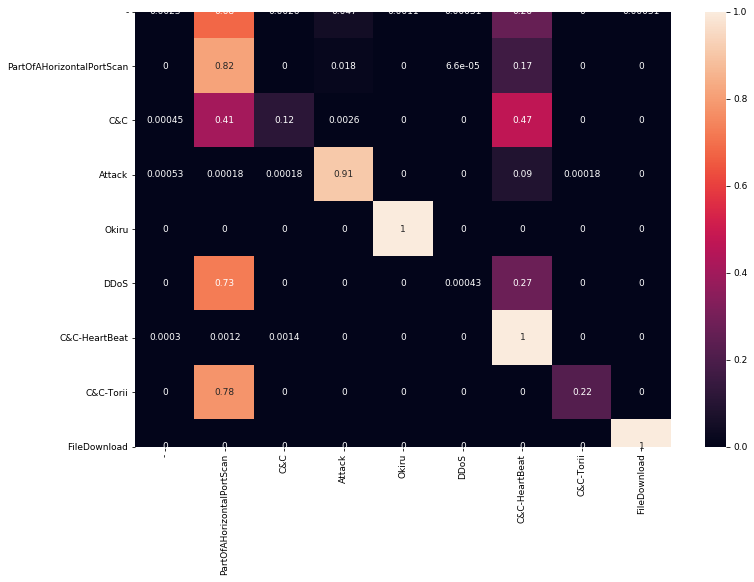

In [143]:
con_mat(y_test, y_pred)

# big = big.drop('enum', axis = 1) -

In [147]:
%%time
grid_bayes.fit(X_train, y_train)

Wall time: 37.1 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [148]:
y_pred = grid_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.536859661034826

In [149]:
pre = precision_score(y_test, y_pred, average = 'weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.6711744976606534,0.536859661034826,0.42873181160763474


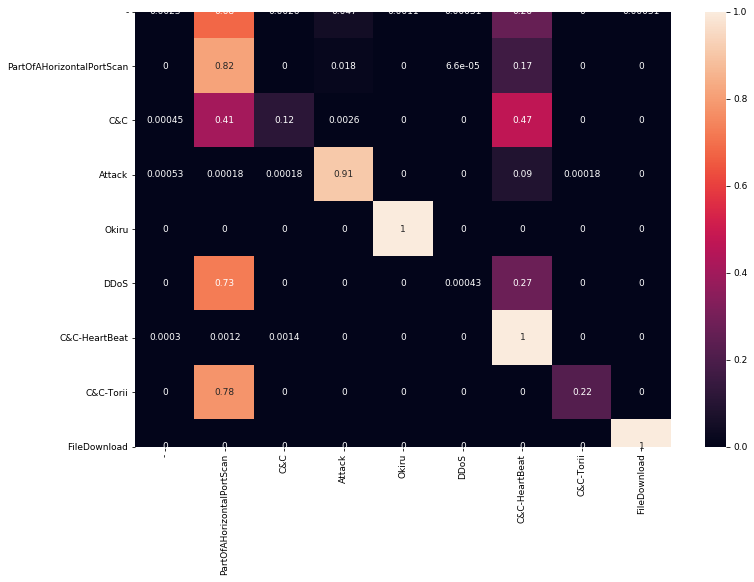

In [150]:
con_mat(y_test, y_pred)

# big = big.drop('set[string]', axis = 1) -

In [155]:
%%time
grid_bayes.fit(X_train, y_train)

Wall time: 33.1 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [156]:
y_pred = grid_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.536859661034826

In [157]:
pre = precision_score(y_test, y_pred, average = 'weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.6711744976606534,0.536859661034826,0.42873181160763474


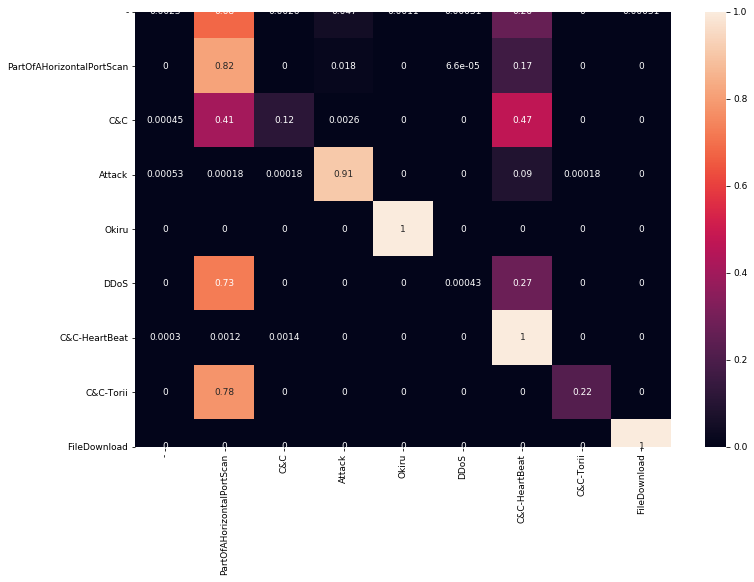

In [158]:
con_mat(y_test, y_pred)

# big = big.drop('count', axis = 1) -

In [162]:
%%time
grid_bayes.fit(X_train, y_train)

Wall time: 33.1 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [163]:
y_pred = grid_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.5467346091221316

In [164]:
pre = precision_score(y_test, y_pred, average = 'weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.569716673636233,0.5467346091221316,0.4371518434995972


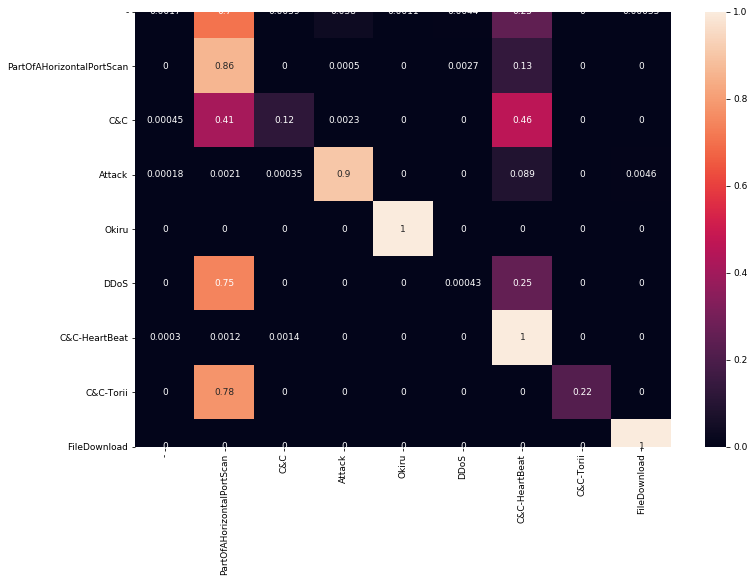

In [165]:
con_mat(y_test, y_pred)

# big = big.drop('count.1', axis = 1) +

In [169]:
%%time
grid_bayes.fit(X_train, y_train)

Wall time: 32.1 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [170]:
y_pred = grid_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.5390020896919517

In [171]:
pre = precision_score(y_test, y_pred, average = 'weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.5133277439969944,0.5390020896919517,0.4278451841593048


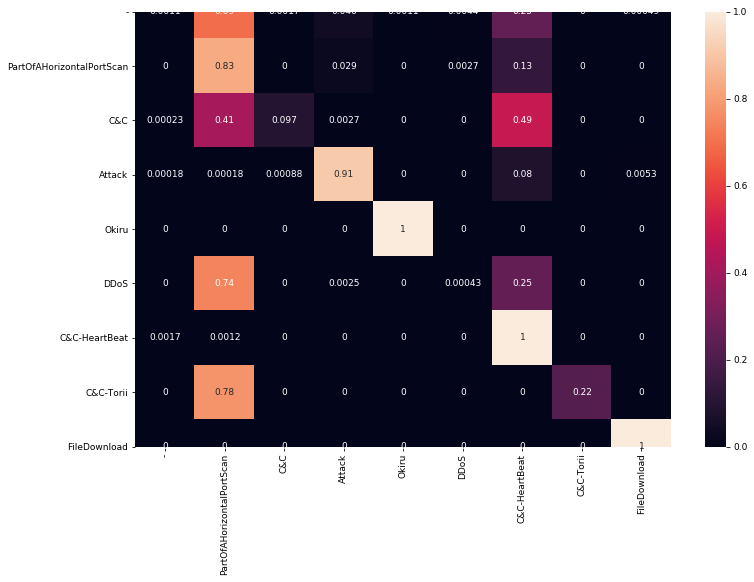

In [172]:
con_mat(y_test, y_pred)

# big = big.drop('count.2', axis = 1) +

In [175]:
%%time
grid_bayes.fit(X_train, y_train)

Wall time: 30.3 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [176]:
y_pred = grid_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.49546134729098135

In [177]:
pre = precision_score(y_test, y_pred, average = 'weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.4945674674225592,0.49546134729098135,0.39714456460603814


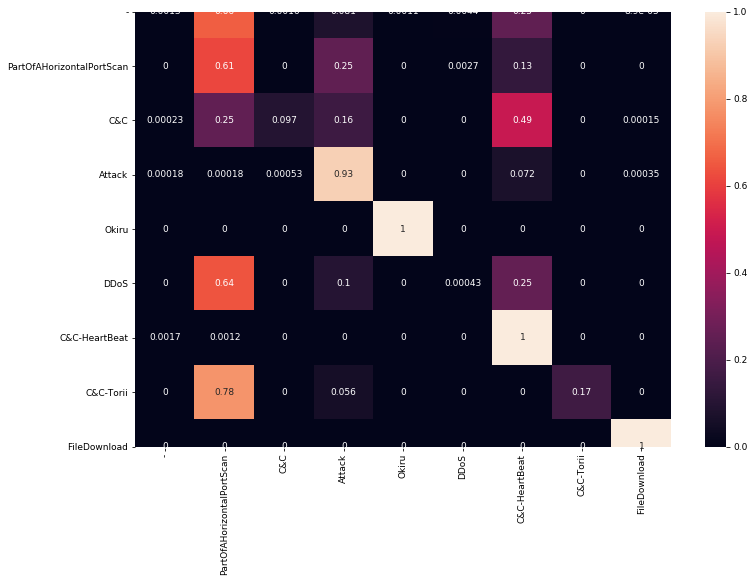

In [178]:
con_mat(y_test, y_pred)

# Проверка первых выводов

In [179]:
big = start

In [182]:
big

,addr,port,addr.1,port.1,enum,string.1,interval,count,count.1,string.2,count.2,string.3,count.3,count.4,count.5,count.6,set[string],string.5
0,1709,58687,67767,123,2,0,0.114184,48,48,10,0,12,1,76,1,76,1,0
1,1709,1900,75195,1900,2,0,160.367579,7536,0,6,0,5,24,8208,0,0,1,0
2,1709,32893,67768,123,2,0,0.016986,48,48,10,0,12,1,76,1,76,1,0
3,1709,53395,62628,443,1,0,0.003497,0,0,10,0,140,5,212,3,144,1,0
4,1709,52801,41560,53,2,2,0.036724,34,311,10,0,12,1,62,1,339,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252822,1716,24104,3554,23,1,0,-1.000000,-1,-1,6,0,25,1,40,0,0,1,0
252823,1716,52989,77180,23,1,0,-1.000000,-1,-1,6,0,25,1,40,0,0,1,0
252824,1716,24104,2962,23,1,0,-1.000000,-1,-1,6,0,25,1,40,0,0,1,0
252825,1716,52989,97490,23,1,0,-1.000000,-1,-1,6,0,25,1,40,0,0,1,0


In [183]:
big_test = big.drop('enum', axis = 1)
big_test = big.drop('set[string]', axis = 1)
big_test = big.drop('count', axis = 1)
big_test = big.drop('interval', axis = 1)

In [197]:
y = big['string.5']
x = big.drop('string.5', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10, test_size=0.6)

y_t = big_test['string.5']
x_t = big_test.drop('string.5', axis = 1)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(x_t, y_t, random_state=10, test_size=0.6)

In [204]:
grid_bayes = GaussianNB()

In [205]:
grid_bayes_t = GaussianNB()

In [206]:
%%time
grid_bayes.fit(X_train, y_train)

Wall time: 49.1 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [207]:
%%time
grid_bayes_t.fit(X_train_t, y_train_t)

Wall time: 44.1 ms


GaussianNB(priors=None, var_smoothing=1e-09)

In [208]:
y_pred = grid_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.5534321707087154

In [209]:
y_pred_t = grid_bayes_t.predict(X_test_t)
accuracy_score(y_test_t, y_pred_t)

0.5544737206404873

In [210]:
pre = precision_score(y_test, y_pred, average = 'weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.7152960676000837,0.5534321707087154,0.46045831991662173


In [211]:
pre = precision_score(y_test_t, y_pred_t, average = 'weighted')
rec = recall_score(y_test_t, y_pred_t, average='weighted')
f1 = f1_score(y_test_t, y_pred_t, average='weighted')

data = [['precision','recall','f1'],
        [pre,rec,f1]]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

precision,recall,f1
0.7067462587631229,0.5544737206404873,0.46289757292980255


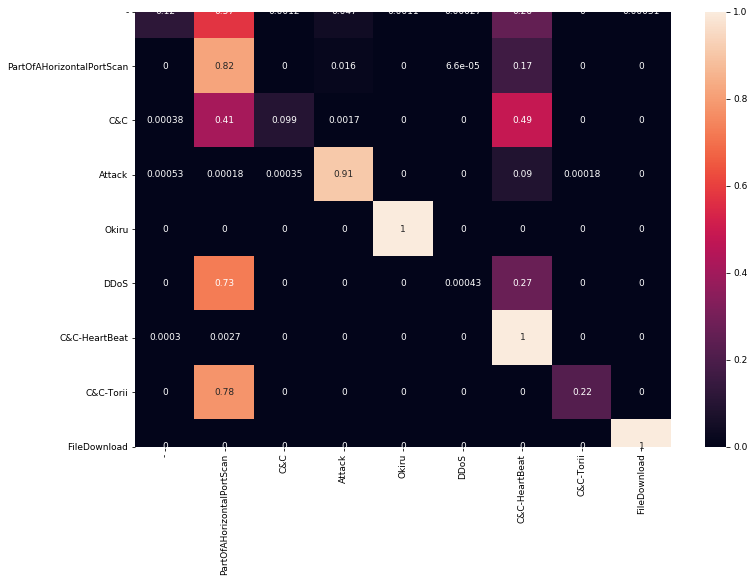

In [212]:
con_mat(y_test, y_pred)

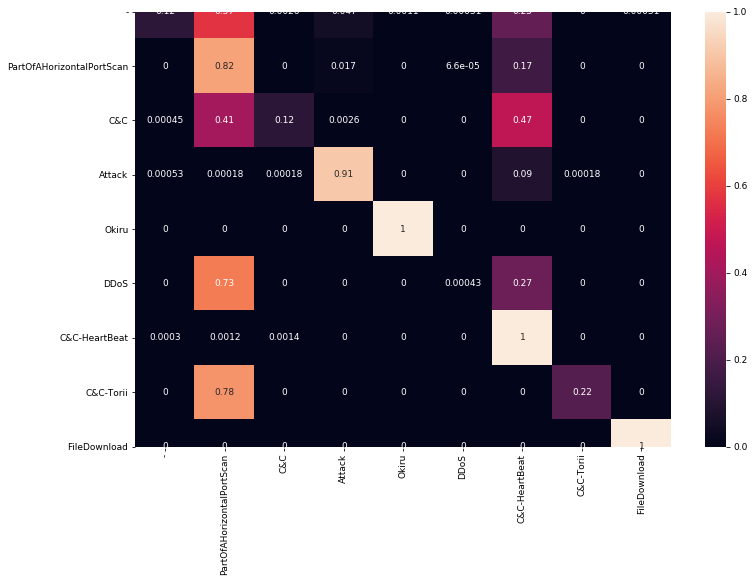

In [213]:
con_mat(y_test_t, y_pred_t)